In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sqlite3
import matplotlib.pyplot as plt
import collections
import rdkit.Chem as chem

In [2]:
db = sqlite3.connect('../chembl_24.db')
c = db.cursor()

Using assay identifier

In [3]:
chembl_assay_id = pd.read_csv("../assay_identifier.txt", delimiter='\t', skiprows=2, usecols=[2])
chembl_assay_id = list(chembl_assay_id['ChEMBL assay identifier'])

assay_id = c.execute("SELECT assay_id, bao_format, chembl_id FROM assays WHERE chembl_id IN " + str(tuple(chembl_assay_id))).fetchall()
assay_id = [i[0] for i in assay_id if i[1] == 'BAO_0000218']

Using document identifier

In [4]:
document_identifiers = pd.read_csv("../document_identifier.txt", delimiter='\t', skiprows=2, usecols=[6])
document_identifiers = list(document_identifiers['ChEMBL document identifier'])

unique_doc_id = c.execute("SELECT doc_id FROM docs WHERE chembl_id IN " + str(tuple(document_identifiers))).fetchall()
unique_doc_id = [i[0] for i in unique_doc_id]

Get agrochemicals

In [5]:
compounds1 = c.execute("SELECT act.molregno, " #0
                      "act.assay_id, " #1
                      "act.doc_id, " #2
                      "act.standard_type, " #3
                      "act.standard_relation, " #4
                      "act.standard_value, " #5
                      "act.standard_units, " #6
                      "p.full_mwt, " #7
                      "s.canonical_smiles " #8
                      "FROM activities act " 
                      "LEFT JOIN compound_properties p ON act.molregno = p.molregno " 
                      "JOIN compound_structures s ON p.molregno = s.molregno " 
                      "WHERE act.assay_id IN %s " 
                      "AND act.doc_id IN %s " 
                      "AND act.data_validity_comment IS NULL "
                      "AND s.canonical_smiles != '' "
                      "AND act.standard_flag = 1 "
                      "AND act.potential_duplicate = 0" %(str(tuple(assay_id)), str(tuple(unique_doc_id)))
                     ).fetchall()

In [6]:
s = list(set(compounds1))
s = [list(i) for i in s]
len(s)

72917

In [7]:
unique_molregno = list(set([i[0] for i in s]))
len(unique_molregno)

12248

Functions

In [8]:
def find_min_activity(my_list, match):
    matches = [i for i in my_list if i[0] == match]
    if not all([i[6] == matches[0][6] for i in matches]):
        raise Exception("Units are not the same!")
    min_idx = np.argmin([i[5] for i in matches])
    return matches[min_idx]

def classify(compound):
    if compound[6] == 'nM':
        if compound[5] < 100.0:
            return 0
        elif compound[5] >= 100.0 and compound[5] < 10000.0:
            return 1
        else:
            return 2
    elif compound[6] == '%':
        if compound[5] > 75.0:
            return 0
        elif compound[5] > 50.0 and compound[5] <= 75.0:
            return 1
        else:
            return 2
    else:
        raise Exception("Unit %s is not standard." %compound[6])

### IC50

In [9]:
ic50_ugmL = [i for i in s if i[3] == 'IC50' and i[6] == 'ug.mL-1']
ic50_nM = [i for i in s if i[3] == 'IC50' and i[6] == 'nM']
len(ic50_nM), len(ic50_ugmL)

(1766, 706)

In [10]:
for i in ic50_ugmL:
    i[5] = float(i[5])*1.E6/float(i[7])
    i[6] = 'nM'

In [11]:
ic50_nM.extend(ic50_ugmL)

In [12]:
unique_ic50_molregno = list(set([i[0] for i in ic50_nM]))
len(ic50_nM), len(unique_ic50_molregno)

(2472, 1390)

In [13]:
ic50 = [find_min_activity(ic50_nM, x) for x in unique_ic50_molregno]

Text(0.5,0,'$log_{10}$ IC50 (nM)')

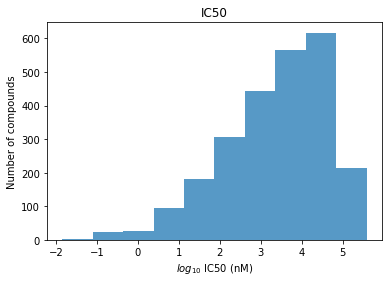

In [14]:
fig, ax = plt.subplots()
ax.set_title("IC50")
ax.hist(np.log10([i[5] for i in ic50_nM]), alpha=0.75)
ax.set_ylabel("Number of compounds")
ax.set_xlabel("$log_{10}$ IC50 (nM)")

### EC50

In [15]:
ec50_ugmL = [i for i in s if i[3] == 'EC50' and i[6] == 'ug.mL-1']
ec50_nM = [i for i in s if i[3] == 'EC50' and i[6] == 'nM']
len(ec50_nM), len(ec50_ugmL)

(1163, 2589)

In [16]:
for i in ec50_ugmL:
    i[5] = float(i[5])*1.E6/float(i[7])
    i[6] = 'nM'

In [17]:
ec50_nM.extend(ec50_ugmL)

In [18]:
unique_ec50_molregno = list(set([i[0] for i in ec50_nM]))
len(ec50_nM), len(unique_ec50_molregno)

(3752, 1174)

In [19]:
ec50 = [find_min_activity(ec50_nM, x) for x in unique_ec50_molregno]

Text(0.5,0,'$log_{10}$ EC50 (nM)')

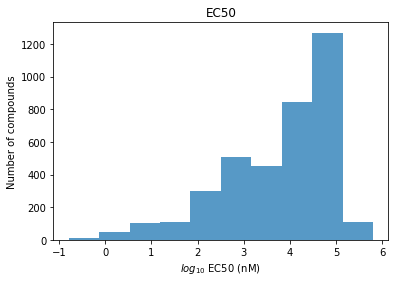

In [20]:
fig, ax = plt.subplots()
ax.set_title("EC50")
ax.hist(np.log10([i[5] for i in ec50_nM]), alpha=0.75)
ax.set_ylabel("Number of compounds")
ax.set_xlabel("$log_{10}$ EC50 (nM)")

### LC50

In [21]:
lc50_ugmL = [i for i in s if i[3] == 'LC50' and i[6] == 'ug.mL-1']
lc50_nM = [i for i in s if i[3] == 'LC50' and i[6] == 'nM']
len(lc50_nM), len(lc50_ugmL)

(301, 1248)

In [22]:
for i in lc50_ugmL:
    i[5] = float(i[5])*1.E6/float(i[7])
    i[6] = 'nM'

In [23]:
lc50_nM.extend(lc50_ugmL)

In [24]:
unique_lc50_molregno = list(set([i[0] for i in lc50_nM]))
len(lc50_nM), len(unique_lc50_molregno)

(1549, 614)

In [25]:
lc50 = [find_min_activity(lc50_nM, x) for x in unique_lc50_molregno]

Text(0.5,0,'$log_{10}$ LC50 (nM)')

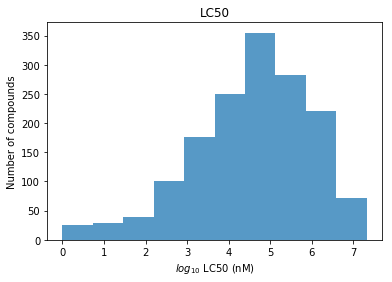

In [26]:
fig, ax = plt.subplots()
ax.set_title("LC50")
ax.hist(np.log10([i[5] for i in lc50_nM]), alpha=0.75)
ax.set_ylabel("Number of compounds")
ax.set_xlabel("$log_{10}$ LC50 (nM)")

### Inhibition

In [27]:
inhibition = [i for i in s if i[3] == 'Inhibition' and i[6] == '%']
len(inhibition)

13741

In [28]:
unique_inhibition_molregno = list(set([i[0] for i in inhibition]))
len(unique_inhibition_molregno)

3406

In [29]:
inhibition = [find_min_activity(inhibition, x) for x in unique_inhibition_molregno]

Text(0.5,0,'%')

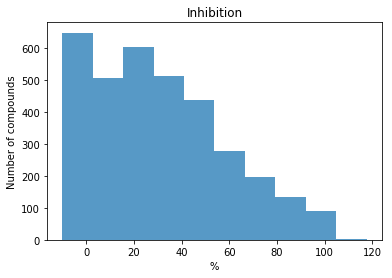

In [30]:
fig, ax = plt.subplots()
ax.set_title("Inhibition")
ax.hist(([i[5] for i in inhibition]), alpha=0.75)
ax.set_ylabel("Number of compounds")
ax.set_xlabel("%")

### Check for compounds with active/inactive activity_comments

In [31]:
compounds2 = c.execute("SELECT act.molregno, " #0
                      "act.assay_id, " #1
                      "act.doc_id, " #2
                      "act.standard_type, " #3
                      "act.standard_relation, " #4
                      "act.standard_value, " #5
                      "act.standard_units, " #6
                      "p.full_mwt, " #7
                      "s.canonical_smiles, " #8
                      "act.activity_comment " #9
                      "FROM activities act " 
                      "LEFT JOIN compound_properties p ON act.molregno = p.molregno " 
                      "JOIN compound_structures s ON p.molregno = s.molregno " 
                      "WHERE act.assay_id IN %s " 
                      "AND act.doc_id IN %s " 
                      "AND act.data_validity_comment IS NULL "
                      "AND s.canonical_smiles IS NOT NULL "
                      "AND act.activity_comment IS NOT NULL "
                      "AND act.standard_type NOT IN ('IC50', 'EC50', 'LC50', 'Inhibition') "
                      "AND act.activity_comment IN ('Active', 'Not Active') "
#                       "AND act.standard_flag = 1 "
                      "AND act.potential_duplicate = 0" %(str(tuple(assay_id)), str(tuple(unique_doc_id)))
                     ).fetchall()

In [32]:
s2 = list(set(compounds2))
s2 = [list(i) for i in s2]
len(s2)

19650

In [33]:
non_unique_activity_molregno = [i[0] for i in s2]
unique_activity_molregno = list(set(non_unique_activity_molregno))
len(non_unique_activity_molregno), len(unique_activity_molregno)

(19650, 4060)

In [34]:
idx = [non_unique_activity_molregno.index(i) for i in unique_activity_molregno]
activity_comment = [s2[i] for i in idx]

In [35]:
for i in s2:
    if i[9] == 'Active':
        i[9] = 0
    elif i[9] == 'Not Active':
        i[9] = 2

Merge all lists into one

In [36]:
activity = []
for i in [ic50, ec50, lc50, inhibition]:
    activity.extend(i)

In [37]:
for i in activity:
    i.append(classify(i))

In [38]:
activity.extend(activity_comment)

Remove duplicated compounds and only take the most active case

In [39]:
molregno = [i[0] for i in activity]
dup_molregno = set([item for item, count in collections.Counter(molregno).items() if count > 1])

In [40]:
duplicates = []
for i in dup_molregno:
    matches = [j for j in activity if j[0] == i]
    c = np.argmin([m[9] for m in matches])
    duplicates.append(matches[c])

In [41]:
activity = [i for i in activity if i[0] not in dup_molregno]
activity.extend(duplicates)

Convert to pandas dataframe

In [42]:
data = pd.DataFrame(activity, columns=['molregno', 'assay_id', 'doc_id', 'type', 'relation', 'value', 'unit', 'mwt', 'smiles', 'agrochemical'])
data

,molregno,assay_id,doc_id,type,relation,value,unit,mwt,smiles,agrochemical
0,114777,931224,71436,IC50,=,11060.000000,nM,227.72,C\C(=N\N=C(/N)\S)\c1ccc(Cl)cc1,2
1,335978,931027,71549,IC50,=,3038.881026,nM,240.22,[O-][N+](=O)c1ccc2[nH]c(nc2c1)c3ccccn3,1
2,934012,922677,70765,IC50,>,17424.712822,nM,257.68,Clc1ccc(cc1)c2oc(nn2)c3cccnc3,2
3,1491083,922588,70740,IC50,>,100000.000000,nM,369.85,CC(C1NC(=O)NC(=C1C(=O)Nc2ccccc2Cl)C)c3ccccc3,2
4,1491084,922588,70740,IC50,>,100000.000000,nM,324.41,CC1=C(C(NC(=S)N1)c2ccccc2)C(=O)Oc3ccccc3,2
5,1491085,922588,70740,IC50,>,100000.000000,nM,268.36,COC(=O)C1=C(C)NC(=S)NC1c2cccs2,2
6,1491086,922588,70740,IC50,=,7900.000000,nM,296.42,CCCOC(=O)C1=C(C)NC(=S)NC1c2cccs2,1
7,1491088,922588,70740,IC50,>,100000.000000,nM,468.97,CC1=C(C(NC(=O)N1)c2cnc(CS)n2Nc3ccccc3)C(=O)Nc4...,2
8,1491089,922588,70740,IC50,>,100000.000000,nM,468.97,CC1=C(C(NC(=O)N1)c2cnc(CS)n2Nc3ccccc3)C(=O)Nc4...,2
9,1491091,922588,70740,IC50,=,67000.000000,nM,483.00,CC1=C(C(NC(=O)N1)c2cnc(CS)n2NCc3ccccc3)C(=O)Nc...,2


Count number of active, intermediate and inactive compounds (active = 0, intermediate = 1, inactive = 2)

In [43]:
data['agrochemical'].value_counts()

2    6031
0    2039
1    1610
Name: agrochemical, dtype: int64

Add a column containing RDKit Molecule clss

In [44]:
%%time
data['mol'] = data['smiles'].apply(chem.MolFromSmiles)

CPU times: user 3.45 s, sys: 134 ms, total: 3.59 s
Wall time: 3.61 s


In [45]:
data = data.drop(['molregno', 'assay_id', 'doc_id', 'type', 'relation', 'value', 'unit'], axis=1)

Save data to pickle file

In [46]:
data.to_pickle("./data.pkl")